In [2]:
#All this is from tensorflow blog but didn't get what they're trying to say


import pandas  as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
import tensorflow as tf
import matplotlib as mlp
import seaborn as sns


    p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
5     996.50     -8.05    265.38        -8.78    94.4          3.33   
11    996.62     -8.88    264.54        -9.77    93.2          3.12   
17    996.84     -8.81    264.59        -9.66    93.5          3.13   
23    996.99     -9.05    264.34       -10.02    92.6          3.07   
29    997.46     -9.63    263.72       -10.65    92.2          2.94   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5           3.14          0.19       1.96             3.15       1307.86   
11          2.90          0.21       1.81             2.91       1312.25   
17          2.93          0.20       1.83             2.94       1312.18   
23          2.85          0.23       1.78             2.85       1313.61   
29          2.71          0.23       1.69             2.71       1317.19   

    wv (m/s)  max. wv (m/s)  wd (deg)  
5       0.21           0.63     192.7  
11      0.25           0.63     190.

Text(0, 0.5, 'Wind Velocity [m/s]')

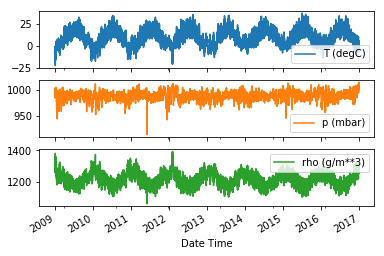

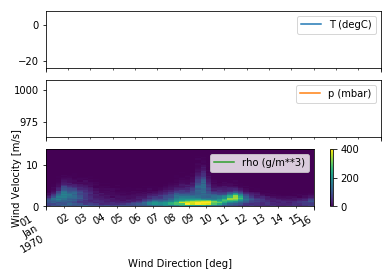

In [3]:
df = pd.read_csv('garbage/climate_data.csv')
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
print(df.head())

plot_col = ['T (degC)','p (mbar)','rho (g/m**3)']
plot_features = df[plot_col]
plot_features.index = date_time
_=plot_features.plot(subplots=True)

plot_features = df[plot_col][:480]
plot_features.index = date_time[:480]
_=plot_features.plot(subplots=True)
df.describe().transpose()

wv = df['wv (m/s)']
bad = wv==-9999
wv[bad] = 0.0

mwv = df['max. wv (m/s)']
mbad = mwv==-9999
mwv[mbad] = 0.0

plt.hist2d(df['wd (deg)'],df['wv (m/s)'],bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [4]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

wv_rad = df.pop('wd (deg)')*np.pi/180

df['Wx']=wv*np.cos(wv_rad)
df['Wy']=wv*np.sin(wv_rad)

df['max Wx']=max_wv*np.cos(wv_rad)
df['max Wy']=max_wv*np.sin(wv_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

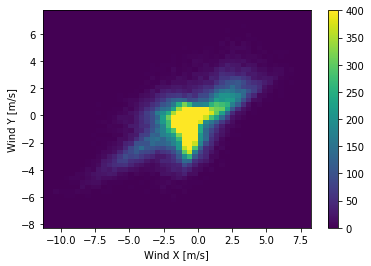

In [5]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50,50), vmax=400)

plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [6]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [7]:
day = 24*60*60
year = (365.2425)*day

df['Day sin']=np.sin(timestamp_s*(2*np.pi/day))
df['Day cos']=np.cos(timestamp_s*(2*np.pi/day))
df['Year sin']=np.sin(timestamp_s*(2*np.pi/year))
df['Year cos']=np.cos(timestamp_s*(2*np.pi/year))

Text(0.5, 1.0, 'Time of day signal')

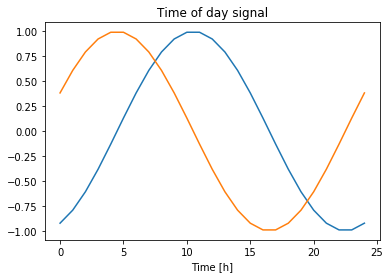

In [8]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

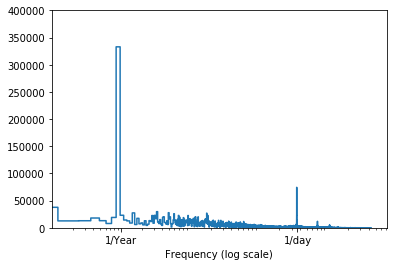

In [9]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0,len(fft))
n_samples_h = len(df['T (degC)'])
hours_per_year = 24*356.2425
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [10]:
column_index = {name:i for i,name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print(num_features)

19


In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df-train_mean)/train_std
val_df = (val_df-train_mean)/train_std
test_df = (test_df-train_mean)/train_std

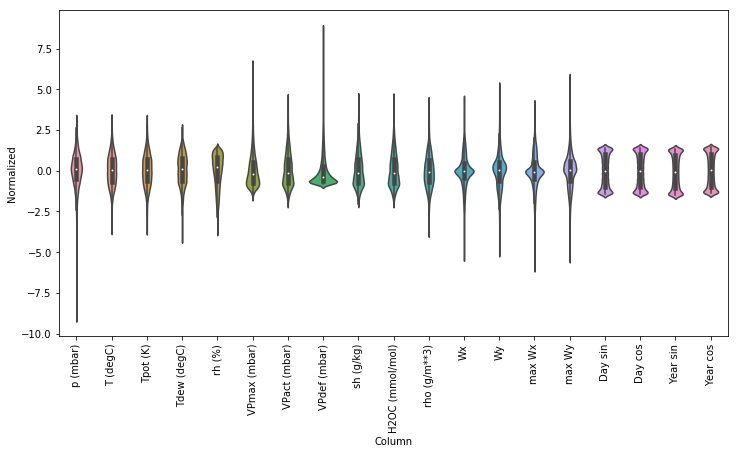

In [12]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [16]:
class WindowGenerator():
    
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        
        self.train_df=train_df
        self.val_df=val_df
        self.test_df=test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_column_indies={name:i for i,name in enumerate(label_columns)}
        
        self.column_indices =  {name:i for i,name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size=input_width + shift
        
        self.input_slice=slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
        
    
    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.label_slice,:]
        
        if self.label_columns is not None:
            labels=tf.stack([labels[:,:,self.column_indices[name]] for name in self.label_columns],axis=-1)
        
        
        inputs.set_shape([None,self.input_width, None])
        labels.set_shape([None,self.label_width,None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12,8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(len(inputs), max_subplots)
        
        for n in range(max_n):
            plt.subplot(3,1,n+1)
            plt.ylabel(f'{plot_col}[normed]')
            plt.plot(self.input_indices, inputs[n,:,plot_col_index],label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_column_indies.get(plot_col,None)#index of 'T deg(c)'
            else:
                label_col_index = plot_col_index
                
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

            
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n,:,label_col_index],marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
            
            if n == 0:
                plt.legend()
        plt.xlabel('Time [h]')
    
    
    def make_dataset(self,data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result=getattr(self,'_example', None)
        
        if result is None:
            result = next(iter(self.train))
            self._example=result
            
        return result
    
# WindowGenerator.make_dataset=make_dataset
# WindowGenerator.plot = plot 
# WindowGenerator.split_window = split_window
# WindowGenerator.plot = plot
# WindowGenerator.example=example

In [56]:
if __name__ == '__main__':
    w1 = WindowGenerator(input_width=6, label_width=1, shift=1,label_columns=['T (degC)'])
    print(w1)
    
    example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                        np.array(train_df[100:100+w1.total_window_size]),
                        np.array(train_df[200:200+w1.total_window_size])])
    
    print(example_window.shape)
    
    example_inputs, example_labels = w1.split_window(example_window)
    w1.example = example_inputs, example_labels

    print('All shapes are: (batch, time, features)')
    print(f'Window shape: {example_window.shape}')
    print(f'Inputs shape: {example_inputs.shape}')
    print(f'labels shape: {example_labels.shape}')
    w1.plot()
    print(w1.train.element_spec)
        

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']
(3, 7, 19)


AttributeError: can't set attribute

In [55]:
example = list(w1.train.take(1).as_numpy_iterator())
print(len(example))
inputs, labels= example[0]
print(np.shape(labels))


1
(32, 1, 1)


In [ ]:
#This is from machinelearningmastery.com 